
乱数から混合行列生成
[[ 1.3315865   0.71527897 -1.54540029 -0.00838385]
 [ 0.62133597 -0.72008556  0.26551159  0.10854853]
 [ 0.00429143 -0.17460021  0.43302619  1.20303737]
 [-0.96506567  1.02827408  0.22863013  0.44513761]]


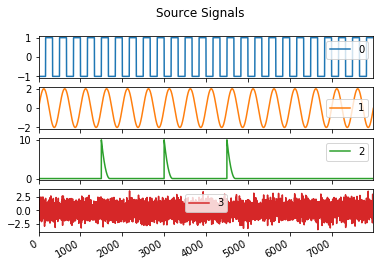

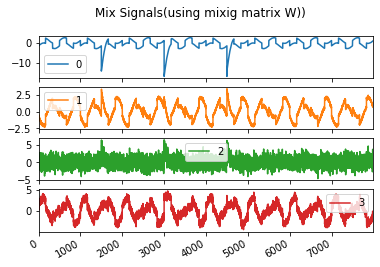

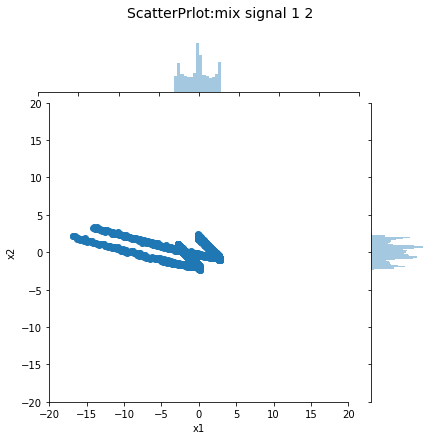

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
===PCA===

特異値分解によるPCA


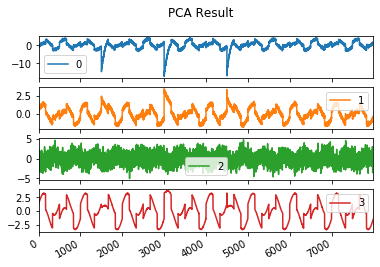

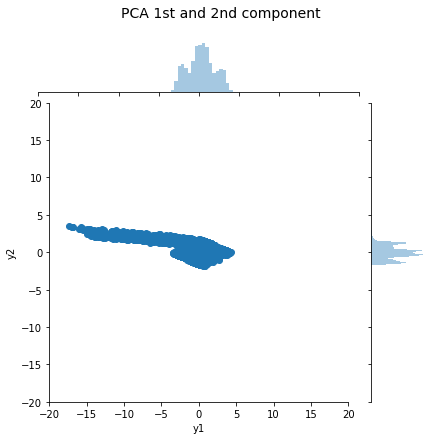


混合行列
[[ 0.93695637 -0.03493062 -0.259399   -0.23152703]
 [-0.17508672  0.54228052  0.02760091 -0.82128842]
 [-0.29357335 -0.23561916 -0.91812899 -0.12384453]
 [ 0.07260911  0.80572657 -0.2983111   0.50650084]]

混合行列(第1主成分のみ)
[[ 0.93695637  0.          0.          0.        ]
 [-0.17508672  0.          0.          0.        ]
 [-0.29357335  0.          0.          0.        ]
 [ 0.07260911  0.          0.          0.        ]]

再構成


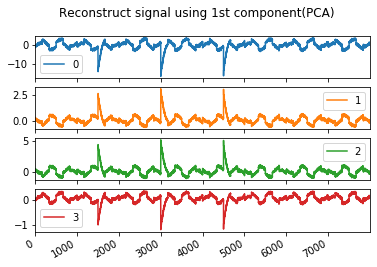

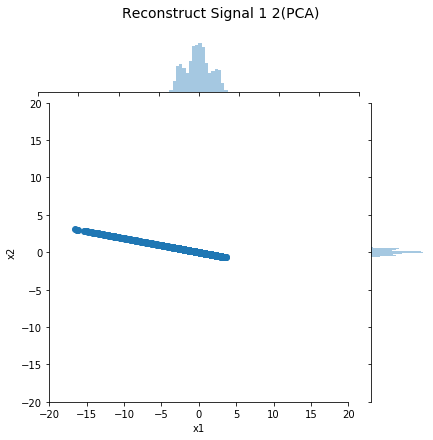

===ICA===
反復回数:477


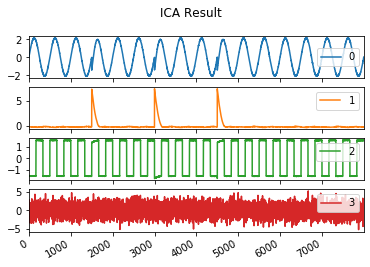

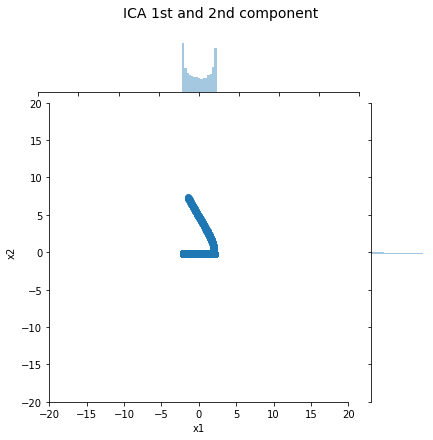


混合行列
[[-0.38249146  1.32350149 -0.05678321  0.52493247]
 [ 0.67962279 -0.03899915 -0.04427009  0.57808246]
 [-0.87401491 -0.66631264 -0.50530017  0.98032686]
 [-0.22529785 -0.14672231  1.31905677  0.36213835]]

混合行列(第2成分のみ)
[[ 0.          1.32350149  0.          0.        ]
 [ 0.         -0.03899915  0.          0.        ]
 [ 0.         -0.66631264  0.          0.        ]
 [ 0.         -0.14672231  0.          0.        ]]

再構成
(4, 8000)


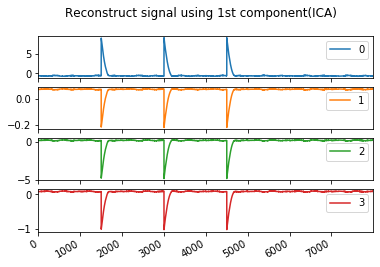

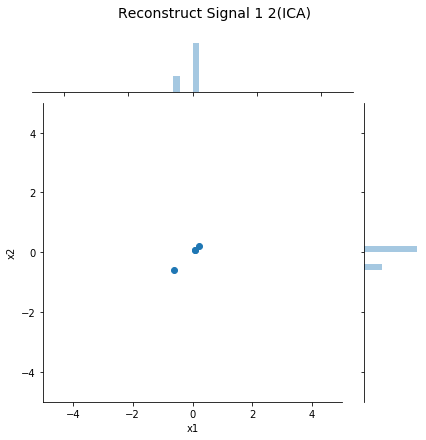

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import warnings
from pandas import plotting 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy import signal
warnings.filterwarnings('ignore')

from picard import picard

#-----------------------------------------------------------
# MEMO:
# Picard(https://pierreablin.github.io/picard/)を事前にpipでインストール
# anacondaの場合は一度仮想環境を作ってからインストール（condaとあまり相性は良くないようだ）
#-----------------------------------------------------------

#グラフのサイズ
range_x_min = -20
range_y_min = -20
range_x_max = 20
range_y_max = 20

#-----------------------------------------------------------
# テスト信号生成
#-----------------------------------------------------------
# triangle
def genTriangle(A, f0, fs, t):
    data = []
    for n in np.arange(t * fs):
        y = 0.0
        for k in range(1,300):
            y += (A / k) * np.sin(2 * np.pi * k * f0 * n / fs)
        data.append(y)
    return data

# square
def genSquare(A, f, fs, t):
    f = f*t
    data = -1.0 * A * signal.square(2 * np.pi * f * np.linspace(0, 1, t*fs, endpoint=False))
    return data

# sine
def genSine(A, f, fs, t):
    data = np.zeros(fs*t)
    for n in np.arange(fs*t):
        data[n] = A * np.sin(2.0 * np.pi * f *  n / fs )
    return data

# spikeのようなやつ
def genSpike(A, fs, t):
    # one spike
    sipkeDuration = 200
    oneSpike = np.zeros(sipkeDuration)
    for n in np.arange(-sipkeDuration, 0):
        oneSpike[n] = n * n #x^2の関数の半分
    oneSpike =A * oneSpike / oneSpike.max()
    
    # sequence
    data = np.zeros(fs*t)
    for n in np.arange(0,sipkeDuration):
        data[n+1500] = oneSpike[n]
    for n in np.arange(0,sipkeDuration):
        data[n+3000] = oneSpike[n]
    for n in np.arange(0,sipkeDuration):
        data[n+4500] = oneSpike[n]
    return data

# 信号生成
fs   = 1000
time = 8
sourceSine   = genSine(2.0, 2.0, fs, time)
sourceSquare = genSquare(1.0, 3.0, fs,time)
sourceSpike  = genSpike(1, fs, time)*10
sourceNR     = np.random.normal(0, 1, fs*time)
sourceMix = np.stack([sourceSquare, sourceSine, sourceSpike, sourceNR])

pd.DataFrame(sourceMix.T).plot(title="Source Signals", subplots=True) #行方向に時間となるように転置
plt.savefig("source_signal.png", dpi=200)

# 混合行列で信号を混合
np.random.seed(10) #乱数のseedを一時的に固定
n = sourceMix.shape[0]
mixW = np.random.randn(n, n)
np.random.seed(None)
print("\n乱数から混合行列生成")
print(mixW)

signalMix = np.dot(mixW, sourceMix)

df = pd.DataFrame(signalMix.T)
df.plot(title="Mix Signals(using mixig matrix W))", subplots=True)
plt.savefig("mix_signal.png", dpi=200)

# 信号1,2の分布
grid = sns.jointplot(df.values[:,0], df.values[:,1])
grid.ax_joint.set_xlabel('x1')
grid.ax_joint.set_ylabel('x2')
grid.ax_joint.set_xlim((range_x_min, range_x_max))
grid.ax_joint.set_ylim((range_y_min, range_y_max))
grid.ax_joint.set_aspect('equal')
plt.subplots_adjust(top=0.9)
plt.suptitle('ScatterPrlot:mix signal 1 2',  fontsize = 14)
plt.show(grid)
grid.savefig("mix_signal_scatter_1_2.png", dpi=200)

#-----------------------------------------------------------
# データの中心化
#-----------------------------------------------------------
avg = df.mean().values
sc = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=False)
dfs = sc.fit_transform(df)
#print(type(df))
#print(type(dfs))

#-----------------------------------------------------------
# PCA 主成分分析の実行
#-----------------------------------------------------------
print('===PCA===')
print("\n特異値分解によるPCA")
U, S, VT = np.linalg.svd(dfs) # 行が時間、列が変数になっているので注意 VTが混合行列 VT.Tとすれば復元行列

'''
print('V : U S V = SVD')
print(VT)
print('V^T')
print(VT.T)
print('VT^-1')
print(np.linalg.inv(VT)) #同じになることを確認
print('V^T x V')
print(np.dot(VT.T,VT))
print('V x V^T')
print(np.dot(VT,VT.T))
'''

# 信号空間に戻す
source = np.dot(VT.T, dfs.T) # 復元行列 x データ^T(説明上一度転置) 行が主成分、列が時間となる
source = source.T            # 表示のために転置

# 結果の表示
## 主成分空間
pd.DataFrame(source).plot(title="PCA Result", subplots=True)
plt.savefig("result_pca_all.png", dpi=200)

## 第1,2主成分の散布図
grid = sns.jointplot(source[:,0], source[:,1])
grid.ax_joint.set_xlabel('y1')
grid.ax_joint.set_ylabel('y2')
grid.ax_joint.set_xlim((range_x_min, range_x_max))
grid.ax_joint.set_ylim((range_y_min, range_y_max))
grid.ax_joint.set_aspect('equal')
plt.subplots_adjust(top=0.9)
plt.suptitle('PCA 1st and 2nd component',  fontsize = 14)
plt.show(grid)
grid.savefig("result_pca_1st_2nd.png", dpi=200)

# 信号の抽出
# 1行目の行ベクトル以外を0
print("\n混合行列")
print(VT)
for i in range(1, 4):
    VT[:,i] = 0 #列を0に
#    VT[i] = 0 #行を0に

print("\n混合行列(第1主成分のみ)")
print(VT)

print("\n再構成")
r = np.dot(VT, source.T) #混合行列 x 主成分データ
r = r.T
r = r + avg #平均値を足す
pd.DataFrame(r).plot(title="Reconstruct signal using 1st component(PCA)", subplots=True)
plt.savefig("reconstruct_signal_pca.png", dpi=200)

grid = sns.jointplot(r[:,0], r[:,1])
grid.ax_joint.set_xlabel('x1')
grid.ax_joint.set_ylabel('x2')
grid.ax_joint.set_xlim((range_x_min, range_x_max))
grid.ax_joint.set_ylim((range_y_min, range_y_max))
grid.ax_joint.set_aspect('equal')
plt.subplots_adjust(top=0.9)
plt.suptitle('Reconstruct Signal 1 2(PCA)',  fontsize = 14)
plt.show(grid)
grid.savefig("reconstruct_signal_pca_1_2.png", dpi=200)

#-----------------------------------------------------------
# ICA 独立分分析の実行 using Picard
#-----------------------------------------------------------
print('===ICA===')
# https://pierreablin.github.io/picard/generated/picard.picard.html#picard.picard
# Estimated un-mixing matrix. The mixing matrix can be obtained by:
# w = np.dot(W, K.T)
# A = np.dot(w.T, np.linalg.inv(np.dot(w, w.T)))
K, W, Y, n_iter = picard(dfs.T, max_iter=1000, tol=1e-8,
                         ortho=False, extended=True,
                         verbose=False, return_n_iter=True, random_state=123456) #乱数固定しているが毎回変わる。。。
print('反復回数:' + str(n_iter))

# 信号源
pd.DataFrame(Y.T).plot(title="ICA Result", subplots=True)
plt.savefig("source_signal_ica.png", dpi=200)

# 散布図
Y_t = Y.T
grid = sns.jointplot(Y_t[:,0], Y_t[:,1])
grid.ax_joint.set_xlabel('x1')
grid.ax_joint.set_ylabel('x2')
grid.ax_joint.set_xlim((range_x_min, range_x_max))
grid.ax_joint.set_ylim((range_y_min, range_y_max))
grid.ax_joint.set_aspect('equal')
plt.subplots_adjust(top=0.9)
plt.suptitle('ICA 1st and 2nd component',  fontsize = 14)
plt.show(grid)
grid.savefig("result_ica_1st_2nd.png", dpi=200)

#-----------------------------------------------------------
# 信号の抽出
#-----------------------------------------------------------
W1 = W.copy()

# 1行目の行ベクトル以外を0
print("\n混合行列")
print(W)

print("\n混合行列(第2成分のみ)")
W1[:,0] = 0
W1[:,2] = 0
W1[:,3] = 0
print(W1)

# 再構成
print("\n再構成")
x = np.dot(W1,Y) #picardで信号源の行列が手に入る
x = x.T + avg #平均を戻す。Picardの場合のYは果たして必要か？
x = x.T
print(x.shape)

pd.DataFrame(x.T).plot(title="Reconstruct signal using 1st component(ICA)", subplots=True)
plt.savefig("reconstruct_signal_ica.png", dpi=200)

grid = sns.jointplot(x[:,0], x[:,1])
grid.ax_joint.set_xlabel('x1')
grid.ax_joint.set_ylabel('x2')
grid.ax_joint.set_xlim((-5, 5))
grid.ax_joint.set_ylim((-5, 5))
grid.ax_joint.set_aspect('equal')
plt.subplots_adjust(top=0.9)
plt.suptitle('Reconstruct Signal 1 2(ICA)',  fontsize = 14)
plt.show(grid)
grid.savefig("reconstruct_signal_ica_1_2.png", dpi=200)